In [1]:
import pathlib

from typing import List, Optional, Dict

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy.optimize import minimize, show_options
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.stats.diagnostic import het_breuschpagan, normal_ad

RangeIndex(start=0, stop=100, step=1)

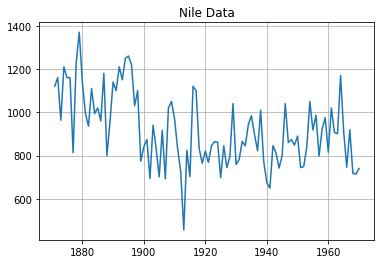

In [2]:
base_dir = pathlib.Path().resolve().parent
data_dir = base_dir / 'data'
nile_path = data_dir / 'Nile.txt'

nile_dates = pd.read_csv(nile_path).index
nile_data = pd.read_csv(nile_path).values

fig, ax = plt.subplots()
ax.plot(range(1871, 1871 + len(nile_data)), nile_data)
ax.grid()
ax.set_title('Nile Data')
nile_dates

In [3]:
def _get_nan_positions(y: np.ndarray) -> List[int]:
    '''
    Find positions of nan elements for the Kalman filter

            Parameters:
                    y (np.Array[float])     : Observed time series which might contain NaN

            Returns:
                    nan_pos_list (List[int]): List of NaN positions
    '''
    
    if y.ndim == 2:
        y = np.squeeze(y)
    
    nan_pos_list = np.squeeze(np.argwhere(np.isnan(y))).tolist()
    
    return nan_pos_list

In [4]:
def _kalman_step(nan_pos_list: List[int], t: int, *args, **params):
    '''
    Computer one step of the kalman filter for the model
    y_t       = alpha_t + epsilon_t  w/ eps ~ N(0, var_eps)
    alpha_t+1 = alpha_t + eta_t      w/ eta ~ N(0, var_eta)

            Parameters:
                    args: variables filled in up until index t-1

            Returns:
                    args: variables filled in up until index t
    '''
    
    y, a, att, p, ptt, f, v, k = args
    
    # retrieve the parameters of the LL model
    var_eta = params['var_eta']
    var_eps = params['var_eps']
    
    # Always true
    a[t] = att[t-1]
    p[t] = ptt[t-1] + var_eta
    
    # If observation is present, proceed normally
    if t not in nan_pos_list:
        
        v[t] = y[t] - a[t]
        f[t] = p[t] + var_eps
        k[t] = p[t] / f[t]

        att[t] = a[t] + k[t] * v[t]
        ptt[t] = p[t] * (1 - k[t])
    
    # If observation is missing, update accordingly
    else:
       
        # variance -> inf because value unknown
        v[t] = np.nan
        f[t] = np.inf
        k[t] = 0
        
        # cannot keep k*v because it will equal nan (want 0)
        att[t] = a[t]
        ptt[t] = p[t]
    
    return a, att, p, ptt, f, v, k

In [5]:
def kalman_filter(y: np.ndarray, diffuse=True, *args, **params):
    '''
    Computer the kalman filter for a local level model given by
    y_t       = alpha_t + epsilon_t  w/ eps ~ N(0, var_eps)
    alpha_t+1 = alpha_t + eta_t      w/ eta ~ N(0, var_eta)

            Parameters:
                    y (np.Array[float])     : Observed time series
                    diffuse (Boolean)       : Whether or not to perform a diffuse initialization
                    params (Dict[str:float]): parameters state matrices

            Returns:
                    a (np.Array[float]): state mean estimate,  a[0] = a_0
                    p (np.Array[float]): state variance estimate, p[0] = p_0
                    f (np.Array[float]): prediction error, f[t] = var(v_t)
                    v (np.Array[float]): prediction variance, v[t] = y[t] - a[t]
                    k (np.Array[float]): Kalman gain, k[t] = p[t] / f[t]
    '''
    
    # retrieve the parameters of the LL model
    var_eta = params['var_eta']
    var_eps = params['var_eps']
    
    # get time horizon from data
    T = len(y)
    
    # get nan positions
    nan_pos_list = _get_nan_positions(y)
    
    # initialize filters
    a, att, p, ptt, f, v, k = np.zeros(T), np.zeros(T), np.zeros(T), np.zeros(T), np.zeros(T), np.zeros(T), np.zeros(T)
    
    # REPLACE BY INIT FUNCTION?
    if diffuse:
        a[0] = 0
        p[0] = 1e7
    
    # Compute values at time t=1
    f[0] = p[0] + var_eps
    v[0] = y[0] - a[0]
    k[0] = p[0] / f[0]
    att[0] = a[0] + k[0] * v[0]
    ptt[0] = p[0] * (1 - k[0])
    
    # Compute values for t = 2,...,T
    for t in range(1, T):

        a, att, p, ptt, f, v, k = _kalman_step(nan_pos_list, t, y, a, att, p, ptt, f, v, k, **params)
    
    #print(np.mean(f))
    return a, att, p, ptt, f, v, k

In [6]:
def kalman_smoother(*args, **params):
    
    '''
    Computer the kalman smoother for a local level model given by
    y_t   = alpha_t + epsilon_t  w/ eps ~ N(0, var_eps)
    m_t+1 = alpha_t + eta_t      w/ eta ~ N(0, var_eta)
    
    Where 
    r_{t-1} = v_t / f_t + L_t * r_t w/ r_n = 0
    a_hat_t = a_t + p_t * r_{t-1} 

            Parameters:
                    y (np.Array[float])     : Observed time series
                    diffuse (Boolean)       : Whether or not to perform a diffuse initialization
                    params (Dict[str:float]): parameters state matrices
                    f (np.Array[float]): prediction variance, f[t] = var(v_t)
                    

            Returns:
                    a (np.Array[float]): state mean estimate,  a[0] = a_0
                    p (np.Array[float]): state variance estimate, p[0] = p_0
                    f (np.Array[float]): prediction error, v[t] = v_t
                    f (np.Array[float]): prediction variance, f[t] = var(v_t)
    '''
    
    # get output of kalman filter
    a, p, f, v, k = args
    
    # get L 
    l = 1 - k
    
    # get time horizon
    T = len(a)
    
    # r_T=0 not included, but need it in loop... shit
    r = np.zeros(T)
    
    # initialize r-and-smoother arrays, need r_0 for a_1, which is at index 0 of a
    r = np.zeros(T+1)
    a_hat = np.zeros(T)
    
    # a_hat[t]: contains a_hat_{t+1}
    # r[t]    : contains r_t
    
    # recursively compute smoothed state
    for t in range(T-1, -1, -1):
        
        if np.isnan(v[t]):
            r[t] = r[t+1]
        
        else:
            # should start at r_{T-1} at index T, and end at r_0 at index 0
            r[t] = v[t] / f[t] + l[t] * r[t+1]
        
        # a_hat_t = a_t + p_t * r_{t-1}
        # should start at a_hat{T} at index T-1, and end at a_1 at index 0
        a_hat[t] = a[t] + p[t] * r[t]
        
    return a_hat, r

In [7]:
def llik(params: np.ndarray, *args) -> float:
    
    '''
    Computes Gaussian log-likelihood for local level model
    y_t   = alpha_t + epsilon_t  w/ eps ~ N(0, var_eps)
    m_t+1 = alpha_t + eta_t      w/ eta ~ N(0, var_eta)
    
    Where 
    r_{t-1} = v_t / f_t + L_t * r_t w/ r_n = 0
    a_hat_t = a_t + p_t * r_{t-1} 

            Parameters:
                    params (np.ndarray)     : Contains parameters
                    args (tuple): contains y -> given my args in minimizer
                    

            Returns:
                    -llik (float): value of log-likelihood for given parameters
    '''
    
    # retrieve parameters
    params_dict = {'var_eta': params[0], 'var_eps': params[1]} 
    
    # retrieve data
    y = args[0]
    
    # get values necessary from Kalman filter
    _, _, _, _, f, v, _ = kalman_filter(y, **params_dict)
    
    
    # If an observation at time t is not present, should not include in log-likelihood
    v = v[~np.isnan(v)]
    f = f[~np.isinf(f)]
    
    # Get the number of present observations
    T = len(f)
    
    # compute log-likelihood
    llik = np.sum( (-1/2) * ( T * np.log(np.pi) + np.log(f[1:]) + np.square(v[1:]) / f[1:]))

    return -llik

# Case 1: Nile data with no missing data

### Key features
- Learns signal to noise ratio
- Can we written down as weighted average of points, but way of averaging justified by log-likelihood
- Time series is non-stationary but could still model using state space model

Parameters: {'var_eta': 1465.989691256304, 'var_eps': 15109.352177353494}


Text(0.5, 1.0, 'Filtered State: Nile Data')

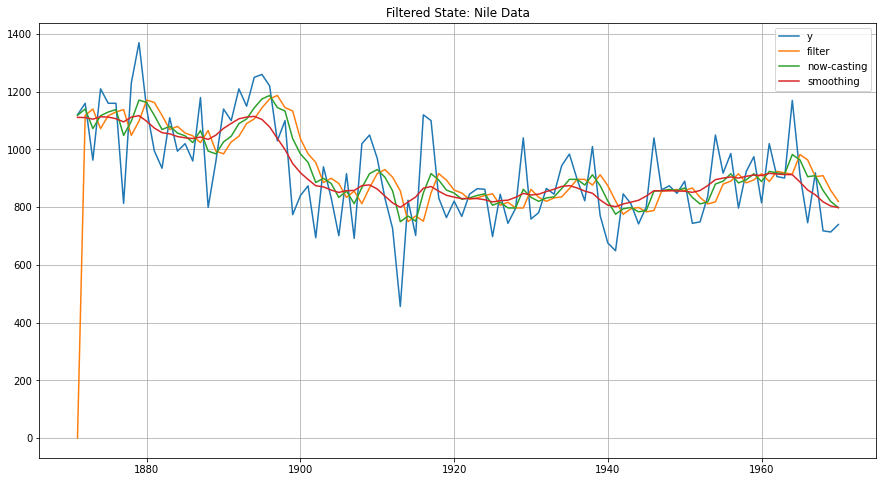

In [8]:
#show_options(solver="minimize", method="BFGS")

options = {
    'eps': 1e-6,
    'disp': True,
    'maxiter':500
}

bnds = ((0, None), (0, None))

var_eta_ini = 500
var_eps_ini = 500
param_ini = np.array([var_eta_ini, var_eps_ini])

res = minimize(llik, param_ini, args=(nile_data, ), method='L-BFGS-B', options=options, bounds=bnds)

params_dict = {'var_eta': res.x[0], 'var_eps': res.x[1]} 
print(f'Parameters: {params_dict}')

a, att, p, ptt, f, v, k = kalman_filter(nile_data, **params_dict)
a_hat,r  = kalman_smoother(a, p, f, v, k, **params_dict)

fig, ax = plt.subplots()
fig.set_size_inches(15,8)

# sanity check in indices
np.argmax(a_hat) == np.argmax(nile_data)

time = range(1871, 1871 + len(nile_data))

ax.plot(time, nile_data, label='y')
ax.plot(time, a, label='filter')

# state matrix T=1, so K=M in s37w2. 
ax.plot(time, att, label='now-casting')
ax.plot(time, a_hat, label='smoothing')
ax.grid()
ax.legend()
ax.set_title('Filtered State: Nile Data')

# Case 2: Nile data *with* missing data

### Key features
- Smoothing automatically interpolates

Parameters: {'var_eta': 2131.8097322063622, 'var_eps': 16003.102056514854}
True


Text(0.5, 1.0, 'Filtered State: Nile Data')

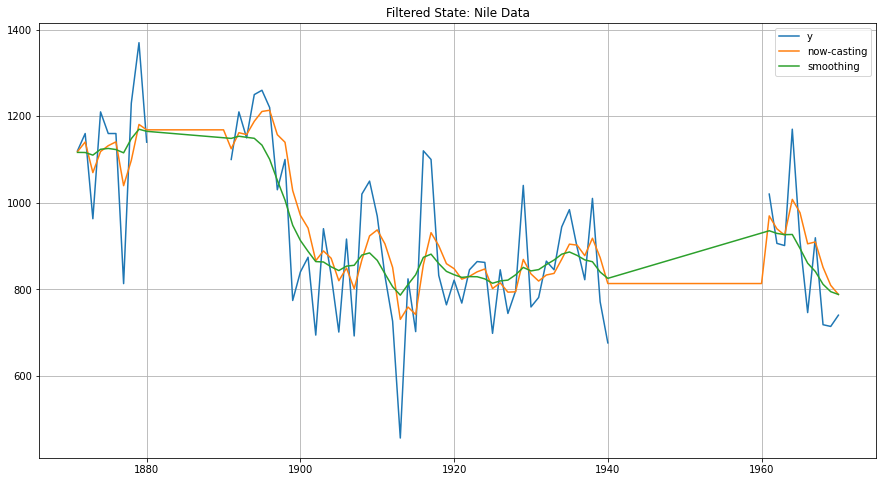

In [9]:
nile_data_copy = np.squeeze(nile_data.copy().astype("float"))
nile_data_copy[10:20] = np.nan
nile_data_copy[70:90] = np.nan

options = {
    'eps': 1e-6,
    'disp': True,
    'maxiter':500
}

bnds = ((0, None), (0, None))


var_eta_ini = 500
var_eps_ini = 500
param_ini = np.array([var_eta_ini, var_eps_ini])

res = minimize(llik, param_ini, args=(nile_data_copy, ), method='L-BFGS-B', options=options, bounds=bnds)

params_dict = {'var_eta': res.x[0], 'var_eps': res.x[1]} 
print(f'Parameters: {params_dict}')

print(res.success)

a, att, p, ptt, f, v, k = kalman_filter(nile_data_copy, **params_dict)
a_hat,r  = kalman_smoother(a, p, f, v, k, **params_dict)

fig, ax = plt.subplots()
fig.set_size_inches(15,8)

time = range(1871, 1871 + len(nile_data))

ax.plot(time, nile_data_copy, label='y')
#ax.plot(time, a, label='filter')

# state matrix T=1, so K=M in s37w2. 
ax.plot(time, att, label='now-casting')
ax.plot(time, a_hat, label='smoothing')
ax.grid()
ax.legend()
ax.set_title('Filtered State: Nile Data')

In [10]:
from scipy.stats import f as f_dist
f_dist.ppf(0.01, 1, 1)
f_dist.cdf(0.6659715102066327, 1, 1)

0.4357431034287245

In [11]:
def _het_test(resid: np.ndarray, diff_elem: int) -> Dict[str, float]:
    """
    test for heteroskedasticity of the residuals
    """
    
    n = len(resid)
    
    # given p92 Commandeur Koopman book
    h = int((n - diff_elem) / 3)
    
    # test of variance, take squares
    square_resid = np.square(resid)
    
    # compute top and bottom of F-statistic
    num = np.sum(square_resid[n - h: n - 1])
    denom = np.sum(square_resid[diff_elem: diff_elem + h - 1])
    
    # notice that len(num)=len(denom), so F-statistic is num/denom (no dof's)
    F_stat = num / denom
    
    H = None
    if F_stat > 1:
        p_val = f_dist.cdf(F_stat, h, h)
    else:
        p_val = f_dist.cdf(1 / F_stat, h, h)
    
    return {'F_stat': F_stat, 'p_val': p_val}

In [12]:
def _normal_test(resid: np.ndarray) -> Dict[str, float]:
    """
    test for normality of the residuals
    """
    
    # get statistic and p_value
    N_stat, p_val = normal_ad(stand_resid)
    
    return {'N_stat': N_stat, 'p_val': p_val}

In [13]:
def _serial_test(resid: np.ndarray, lags: int) -> Dict[str, float]:
    """
    test for serial correlation in the residuals
    """
    
    # acorr_ljungbox expects lags as array
    lags = np.array([lags])
    
    # perform test, returns dataframe
    S_df = acorr_ljungbox(resid, lags=lags)
    
    # store values 
    Q_stat = S_df['lb_stat'].item()
    p_val = S_df['lb_pvalue'].item()
    
    return {'Q_stat': Q_stat, 'p_val': p_val}

{'F_stat': 0.6659715102066327, 'p_val': 0.8317202906912198}
{'N_stat': 0.20180150529657226, 'p_val': 0.8751900208719701}
{'Q_stat': 10.748952048025728, 'p_val': 0.37740859389696946}


(array([ 3.,  1.,  8., 10., 14., 15., 11.,  3.,  4.,  1.]),
 array([-2.60036473, -2.09082187, -1.58127901, -1.07173615, -0.56219329,
        -0.05265043,  0.45689243,  0.96643528,  1.47597814,  1.985521  ,
         2.49506386]),
 <BarContainer object of 10 artists>)

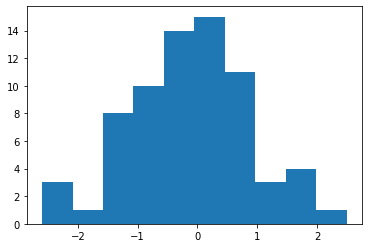

In [14]:
 # If an observation at time t is not present, should not include in diagnostics
v_copy = v[~np.isnan(v)]
f_copy = f[~np.isinf(f)]

stand_resid = v_copy / np.sqrt(f_copy)

H_dict = _het_test(stand_resid, 1)
N_dict = _normal_test(stand_resid)
Q_dict = _serial_test(stand_resid, 10)

print(H_dict)
print(N_dict)
print(Q_dict)

fig, ax = plt.subplots()
ax.hist(stand_resid)

# Creating the local level class

In [15]:
from dataclasses import dataclass
from pathlib import Path

In [16]:
@dataclass
class LocalLevelModel:
    
    data_path: Optional[Path]
    
    params: Dict[str, float] = None
    y, a, att, a_hat, p, ptt, f, v, k, r = None, None, None, None, None, None, None, None, None, None
    resid_diag = {}
    
    def __post_init__(self):
        
        if self.data_path:
            if self.data_path.exists():
                self.y = pd.read_csv(self.data_path).values
            else:
                raise Exception('Path does not exist')
    
    def fit(self, y: Optional[np.ndarray] = None) -> None:
        """
        Fits a local level model and extracts filter (a), in-casted filter (att), smoothed filter (a_hat)
        and all the other instance variables. 
        
                Parameters:
                        y (np.Array[float], Optional)     : Observed time series

                Returns:
                        None
        """
        
        # If data added during construction, use that
        if self.y.tolist():
            y = self.y
        
        # If data not added during construction, should be passed to fit
        else: 
            if not y:
                raise Exception('Need a data source')
        
        options = {
            'eps': 1e-6,
            'disp': True,
            'maxiter':500
        }

        bnds = ((0, None), (0, None))

        var_eta_ini = 500
        var_eps_ini = 500
        param_ini = np.array([var_eta_ini, var_eps_ini])

        res = minimize(self._llik, param_ini, args=(self.y, ), method='L-BFGS-B', options=options, bounds=bnds)

        params_dict = {'var_eta': res.x[0], 'var_eps': res.x[1]} 
        print(f'Parameters: {params_dict}')

        self.a, self.att, self.p, self.ptt, self.f, self.v, self.k = self._kalman_filter(self.y, **params_dict)
        self.a_hat, self.r  = self._kalman_smoother(self.a, self.p, self.f, self.v, self.k, **params_dict)
        
    def residual_diagnostics(self, *args, **kwargs) -> List[Dict[str, float]]:
        """
        Does residual diagnostics to assess model specification
        
                Parameters:
                        resid (np.Array[float], Optional)     : Observed time series

                Returns:
                        None
        
        """
        
        v, f = None, None
        
        if self.v is None or self.f is None:
            raise Exception('model not yet fitted')
        else:
            v = self.v
            f = self.f
            
        # If an observation at time t is not present, should not include in diagnostics
        v = v[~np.isnan(v)]
        f = f[~np.isinf(f)]
        
        # standardize the residuals
        stand_resid = v / np.sqrt(f)
        
        print(stand_resid)
        
        H_dict = self._het_test(stand_resid, 1)
        N_dict = self._normal_test(stand_resid)
        Q_dict = self._serial_test(stand_resid, 10)

        print(H_dict)
        print(N_dict)
        print(Q_dict)
        
        return [H_dict, N_dict, Q_dict]
    
    def _get_nan_positions(self, y: np.ndarray) -> List[int]:
        '''
        Find positions of nan elements for the Kalman filter

                Parameters:
                        y (np.Array[float])     : Observed time series which might contain NaN

                Returns:
                        nan_pos_list (List[int]): List of NaN positions
        '''

        if y.ndim == 2:
            y = np.squeeze(y)

        nan_pos_list = np.squeeze(np.argwhere(np.isnan(y))).tolist()

        return nan_pos_list

    def _kalman_step(self, nan_pos_list: List[int], t: int, *args, **params):
        '''
        Computer one step of the kalman filter for the model
        y_t       = alpha_t + epsilon_t  w/ eps ~ N(0, var_eps)
        alpha_t+1 = alpha_t + eta_t      w/ eta ~ N(0, var_eta)

                Parameters:
                        args: variables filled in up until index t-1

                Returns:
                        args: variables filled in up until index t
        '''

        y, a, att, p, ptt, f, v, k = args

        # retrieve the parameters of the LL model
        var_eta = params['var_eta']
        var_eps = params['var_eps']

        # Always true
        a[t] = att[t-1]
        p[t] = ptt[t-1] + var_eta

        # If observation is present, proceed normally
        if t not in nan_pos_list:

            v[t] = y[t] - a[t]
            f[t] = p[t] + var_eps
            k[t] = p[t] / f[t]

            att[t] = a[t] + k[t] * v[t]
            ptt[t] = p[t] * (1 - k[t])

        # If observation is missing, update accordingly
        else:

            # variance -> inf because value unknown
            v[t] = np.nan
            f[t] = np.inf
            k[t] = 0

            # cannot keep k*v because it will equal nan (want 0)
            att[t] = a[t]
            ptt[t] = p[t]

        return a, att, p, ptt, f, v, k
    
    def _kalman_filter(self, y: np.ndarray, diffuse=True, *args, **params):
        '''
        Computer the kalman filter for a local level model given by
        y_t       = alpha_t + epsilon_t  w/ eps ~ N(0, var_eps)
        alpha_t+1 = alpha_t + eta_t      w/ eta ~ N(0, var_eta)

                Parameters:
                        y (np.Array[float])     : Observed time series
                        diffuse (Boolean)       : Whether or not to perform a diffuse initialization
                        params (Dict[str:float]): parameters state matrices

                Returns:
                        a (np.Array[float]): state mean estimate,  a[0] = a_0
                        p (np.Array[float]): state variance estimate, p[0] = p_0
                        f (np.Array[float]): prediction error, f[t] = var(v_t)
                        v (np.Array[float]): prediction variance, v[t] = y[t] - a[t]
                        k (np.Array[float]): Kalman gain, k[t] = p[t] / f[t]
        '''

        # retrieve the parameters of the LL model
        var_eta = params['var_eta']
        var_eps = params['var_eps']

        # get time horizon from data
        T = len(y)

        # get nan positions
        nan_pos_list = self._get_nan_positions(y)

        # initialize filters
        a, att, p, ptt, f, v, k = np.zeros(T), np.zeros(T), np.zeros(T), np.zeros(T), np.zeros(T), np.zeros(T), np.zeros(T)

        # REPLACE BY INIT FUNCTION?
        if diffuse:
            a[0] = 0
            p[0] = 1e7

        # Compute values at time t=1
        f[0] = p[0] + var_eps
        v[0] = y[0] - a[0]
        k[0] = p[0] / f[0]
        att[0] = a[0] + k[0] * v[0]
        ptt[0] = p[0] * (1 - k[0])

        # Compute values for t = 2,...,T
        for t in range(1, T):

            a, att, p, ptt, f, v, k = self._kalman_step(nan_pos_list, t, y, a, att, p, ptt, f, v, k, **params)

        #print(np.mean(f))
        return a, att, p, ptt, f, v, k
    
    def _kalman_smoother(self, *args, **params):
    
        '''
        Computer the kalman smoother for a local level model given by
        y_t   = alpha_t + epsilon_t  w/ eps ~ N(0, var_eps)
        m_t+1 = alpha_t + eta_t      w/ eta ~ N(0, var_eta)

        Where 
        r_{t-1} = v_t / f_t + L_t * r_t w/ r_n = 0
        a_hat_t = a_t + p_t * r_{t-1} 

                Parameters:
                        y (np.Array[float])     : Observed time series
                        diffuse (Boolean)       : Whether or not to perform a diffuse initialization
                        params (Dict[str:float]): parameters state matrices
                        f (np.Array[float]): prediction variance, f[t] = var(v_t)


                Returns:
                        a (np.Array[float]): state mean estimate,  a[0] = a_0
                        p (np.Array[float]): state variance estimate, p[0] = p_0
                        f (np.Array[float]): prediction error, v[t] = v_t
                        f (np.Array[float]): prediction variance, f[t] = var(v_t)
        '''

        # get output of kalman filter
        a, p, f, v, k = args

        # get L 
        l = 1 - k

        # get time horizon
        T = len(a)

        # r_T=0 not included, but need it in loop... shit
        r = np.zeros(T)

        # initialize r-and-smoother arrays, need r_0 for a_1, which is at index 0 of a
        r = np.zeros(T+1)
        a_hat = np.zeros(T)

        # a_hat[t]: contains a_hat_{t+1}
        # r[t]    : contains r_t

        # recursively compute smoothed state
        for t in range(T-1, -1, -1):

            if np.isnan(v[t]):
                r[t] = r[t+1]

            else:
                # should start at r_{T-1} at index T, and end at r_0 at index 0
                r[t] = v[t] / f[t] + l[t] * r[t+1]

            # a_hat_t = a_t + p_t * r_{t-1}
            # should start at a_hat{T} at index T-1, and end at a_1 at index 0
            a_hat[t] = a[t] + p[t] * r[t]

        return a_hat, r
    
    def _llik(self, params: np.ndarray, *args) -> float:
    
        '''
        Computes Gaussian log-likelihood for local level model
        y_t   = alpha_t + epsilon_t  w/ eps ~ N(0, var_eps)
        m_t+1 = alpha_t + eta_t      w/ eta ~ N(0, var_eta)

        Where 
        r_{t-1} = v_t / f_t + L_t * r_t w/ r_n = 0
        a_hat_t = a_t + p_t * r_{t-1} 

                Parameters:
                        params (np.ndarray)     : Contains parameters
                        args (tuple): contains y -> given my args in minimizer


                Returns:
                        -llik (float): value of log-likelihood for given parameters
        '''

        # retrieve parameters
        params_dict = {'var_eta': params[0], 'var_eps': params[1]} 

        # retrieve data
        y = args[0]

        # get values necessary from Kalman filter
        _, _, _, _, f, v, _ = self._kalman_filter(y, **params_dict)


        # If an observation at time t is not present, should not include in log-likelihood
        v = v[~np.isnan(v)]
        f = f[~np.isinf(f)]

        # Get the number of present observations
        T = len(f)

        # compute log-likelihood
        llik = np.sum( (-1/2) * ( T * np.log(np.pi) + np.log(f[1:]) + np.square(v[1:]) / f[1:]))

        return -llik
    
    def _het_test(self, resid: np.ndarray, diff_elem: int) -> Dict[str, float]:
        """
        Heteroskedasticity test of residuals
        H0: residuals are homoskedastic
        H1: residuals are heteroskedastic
        
                Parameters:
                        resid (np.Array[float])     : standardized residuals

                Returns:
                        Dict[str, float]: Statistic and pvalue
        
        """

        n = len(resid)

        # given p92 Commandeur Koopman book
        h = int((n - diff_elem) / 3)

        # test of variance, take squares
        square_resid = np.square(resid)

        # compute top and bottom of F-statistic
        num = np.sum(square_resid[n - h: n - 1])
        denom = np.sum(square_resid[diff_elem: diff_elem + h - 1])

        # notice that len(num)=len(denom), so F-statistic is num/denom (no dof's)
        F_stat = num / denom

        H = None
        if F_stat > 1:
            p_val = f_dist.cdf(F_stat, h, h)
        else:
            p_val = f_dist.cdf(1 / F_stat, h, h)

        return {'F_stat': F_stat, 'p_val': p_val}
    
    def _normal_test(self, resid: np.ndarray) -> Dict[str, float]:
        """
        Normality test of residuals
        H0: residuals are normally distributed
        H1: residuals are not normally distributed
        
                Parameters:
                        resid (np.Array[float])     : standardized residuals

                Returns:
                        Dict[str, float]: Statistic and pvalue
        
        """

        # get statistic and p_value
        N_stat, p_val = normal_ad(stand_resid)

        return {'N_stat': N_stat, 'p_val': p_val}
    
    def _serial_test(self, resid: np.ndarray, lags: int) -> Dict[str, float]:
        """
        Normality test of residuals
        H0: residuals are serially uncorrelated
        H1: residuals are serially correlated
        
                Parameters:
                        resid (np.Array[float])     : standardized residuals

                Returns:
                        Dict[str, float]: Statistic and pvalue
        
        """

        # acorr_ljungbox expects lags as array
        lags = np.array([lags])

        # perform test, returns dataframe
        S_df = acorr_ljungbox(resid, lags=lags)

        # store values 
        Q_stat = S_df['lb_stat'].item()
        p_val = S_df['lb_pvalue'].item()

        return {'Q_stat': Q_stat, 'p_val': p_val}

In [17]:
llm = LocalLevelModel(nile_path)
llm.fit()
llm.residual_diagnostics()
llm.a_hat

Parameters: {'var_eta': 1465.989691256304, 'var_eps': 15109.352177353494}
[ 0.35390783  0.23429349 -1.13207648  0.92068852  0.29368771  0.20869941
 -2.25309833  1.25841143  1.89218626 -0.2168519  -1.168455   -1.27405568
  0.28509155 -0.59903888 -0.25808801 -0.60721196  1.08735639 -1.85687317
 -0.2539196   1.08169289  0.51451345  1.14358003  0.42056661  1.00502843
  0.80661969  0.31281271 -1.09424092 -0.31472427 -2.50182499 -1.37472714
 -0.77118656 -1.81943956  0.37959733 -0.46705837 -1.26204453  0.57235911
 -1.14078143  1.44848114  1.2711179   0.36779219 -0.69167322 -1.23865465
 -2.78919558  0.5184069  -0.46976972  2.5674893   1.7433313  -0.58866601
 -0.90536576 -0.26679131 -0.56484909  0.12222696  0.22198686  0.1488432
 -1.03334814  0.26633955 -0.50830833 -0.01047357  1.69212254 -0.71677903
 -0.3723307   0.31215948  0.08956868  0.75535186  0.83253197  0.00439247
 -0.51925941  0.92892724 -0.98381725 -1.38321068 -1.2023579   0.49073018
  0.12297932 -0.39747137  0.11956452  1.75264337  0

array([1111.20844625, 1110.51834497, 1105.0272704 , 1113.31643683,
       1112.22484985, 1106.49786376, 1095.57981592, 1112.07916442,
       1117.13720641, 1097.66115559, 1074.07716496, 1058.16566135,
       1054.20434513, 1044.82943779, 1040.38627279, 1037.92109237,
       1043.01623067, 1034.82047528, 1049.50527635, 1073.06840591,
       1090.13747631, 1106.24963221, 1112.29537575, 1114.68281615,
       1103.94106383, 1078.05764369, 1038.40222138,  999.56202725,
        950.97680695,  919.56281751,  895.8684357 ,  874.2958458 ,
        870.21651758,  859.36642482,  851.0745428 ,  857.34369093,
        857.92169205,  874.59829802,  877.1672577 ,  862.96706569,
        838.47899457,  814.71657527,  799.56190985,  817.7414478 ,
        835.31374773,  865.82085635,  871.66615287,  855.35728539,
        841.31466595,  834.77352651,  829.56876785,  830.33773843,
        829.68409843,  825.70094719,  818.19586883,  822.3528328 ,
        824.31244818,  834.06440434,  847.50957141,  842.27829